## IMPORTACIÓN DE LIBRERIAS Y OBTENCION DE LOS DATOS

In [140]:
# importamos las librerias necesarias
import json
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re
import unicodedata
import numpy as np
from nltk import ngrams 
from nltk.probability import FreqDist 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from num2words import num2words
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from time import time  
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [61]:
# obtenemos los datos de las reviews y lo añadimos a un DataFrame

# abrimos el archivo y luego lo leemos y guardamos
reviews_text = []
reviews_overall = []

file = "D:\Bootcamp IA\Practica NLP\software.json"
with open(file, 'r') as fp:
    for line in fp:
        # convertimos 
        data = json.loads(line)
        #  observamos si hay valores nulos o vacios en el campo reviewText y si no lo hay guardamos los valores que necesitamos
        if data.get('reviewText') is not None:  
          reviews_text.append(data.get('reviewText'))
          reviews_overall.append(data.get('overall'))

# añadimos a un dataframe
df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_overall
})

<>:7: SyntaxWarning: invalid escape sequence '\B'
<>:7: SyntaxWarning: invalid escape sequence '\B'
C:\Users\manue\AppData\Local\Temp\ipykernel_20280\2598070230.py:7: SyntaxWarning: invalid escape sequence '\B'
  file = "D:\Bootcamp IA\Practica NLP\software.json"


## VISUALIZACIÓN DE LOS DATOS

In [62]:
# observamos los datos
df.head()

,review,sentiment
0,I've been using Dreamweaver (and it's predeces...,4.0
1,"The demo is done with the PC version, with ref...",4.0
2,If you've been wanting to learn how to create ...,5.0
3,I've been creating websites with Dreamweaver f...,5.0
4,I decided (after trying a number of other prod...,5.0


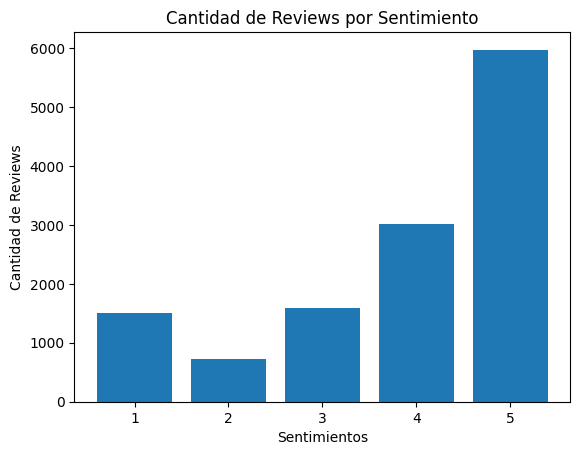

In [63]:
# contamos cuantas reviews hay por cada nota de sentimiento 
cuenta_sentimientos = df['sentiment'].value_counts().sort_index()

# visualizamos como estan distribuidos los datos
fig,ax = plt.subplots()
ax.bar(cuenta_sentimientos.index, cuenta_sentimientos.values)

# añadimos las etiquetas
ax.set_xlabel('Sentimientos')
ax.set_ylabel('Cantidad de Reviews')
ax.set_title('Cantidad de Reviews por Sentimiento')


plt.show()

Tenemos un total de 2245800 palabras.


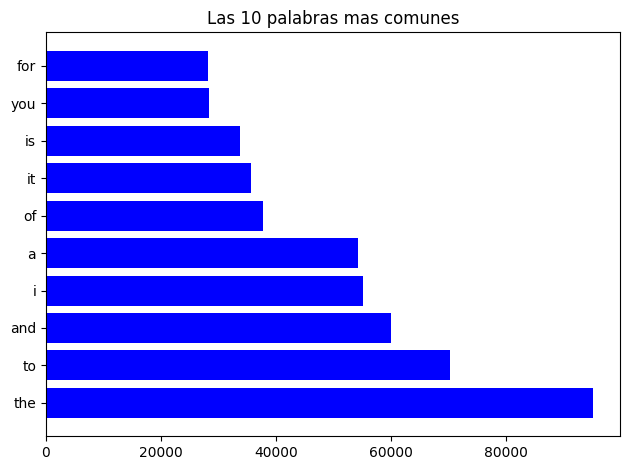

In [64]:
# analizamos el vocabulario y vemos cual son las que mas se estan usando, creamos una funcion para que luego la podemos reutilizar una vez realizado el preprocesado

def counter_plot_most_common(reviews,num_palabras_mas_comunes:int, titulo):
    # pasamos todas las palabras a minusculas y las separamos por espacio para tener los tokens
    split_review = reviews.str.lower().str.split()

    # una vez que lo tenemos como listas, reorganizamos para tenerlo todo en una misma fila y resetemaos el indice para que tenga un orden correcto
    palabras = split_review.apply(pd.Series).stack().reset_index(drop = True)

    # pasamos las palabras a un Counter para visualizar la cantidad de palabras
    counter = Counter(palabras)
    print(f'Tenemos un total de {len(palabras)} palabras.')

    # mostramos a traves de una grafica las mas comunes    
    pal , count = zip(*[(str(bg[0]), bg[1]) for bg in counter.most_common(num_palabras_mas_comunes)])

    fig, ax = plt.subplots(1, 1)  

    ax.barh(pal, count, color='blue')
    ax.set_title(titulo)

    plt.tight_layout()
    plt.show()

    # devolvemos las palabras por si queremos usarlo
    return palabras

palabras = counter_plot_most_common(reviews=df['review'],num_palabras_mas_comunes=10,titulo=f'Las 10 palabras mas comunes')



Como se observa, las palabras mas comunes son stopwords que posteriormente eliminaremos

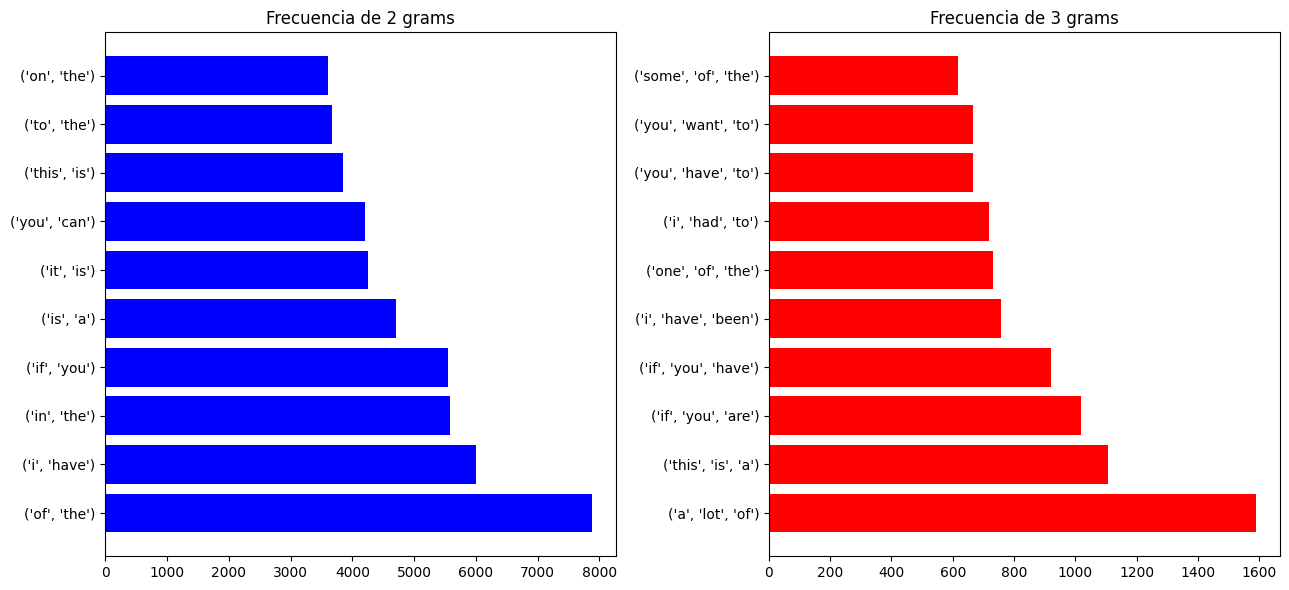

In [65]:
# calculamos los n-gramas mas frecuentes (2,3)

bigrams = ngrams(palabras, 2)
trigrams = ngrams(palabras, 3)

bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)

# mostramos los 10 ngrams mas frecuentes, para ello obt

biGrams , bicount = zip(*[(str(bg[0]), bg[1]) for bg in bigrams_freq.most_common(10)])
triGrams ,triocount = zip(*[(str(bg[0]), bg[1]) for bg in trigrams_freq.most_common(10)])


# graficamos los resultados
fig, axs = plt.subplots(1, 2, figsize=(13, 6)) 


axs[0].barh(biGrams, bicount, color='blue')
axs[0].set_title('Frecuencia de 2 grams')

axs[1].barh(triGrams, triocount, color='red')
axs[1].set_title('Frecuencia de 3 grams')

plt.tight_layout()
plt.show()

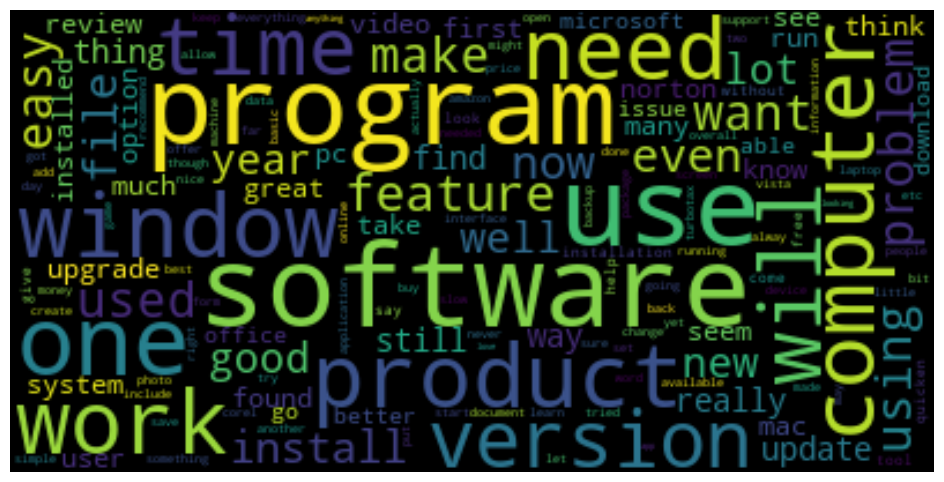

In [66]:
# antes de hacer el preprocesado pasamos el Wordcloud para ver las palabras mas relevantes
##IMPORTANTE## Esta libreria ya elimina stopwords por lo que no apareceran las que obtenemos mas arriba en el Counter.


wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="black").generate(' '.join(palabras))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
# distribucion de los datos de manera binaria( 1:review positivas, 0:review negativa)

def label_sentiment(row):
    if int(row['sentiment']) <= 3:
        return 0
    else:
        return 1

df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

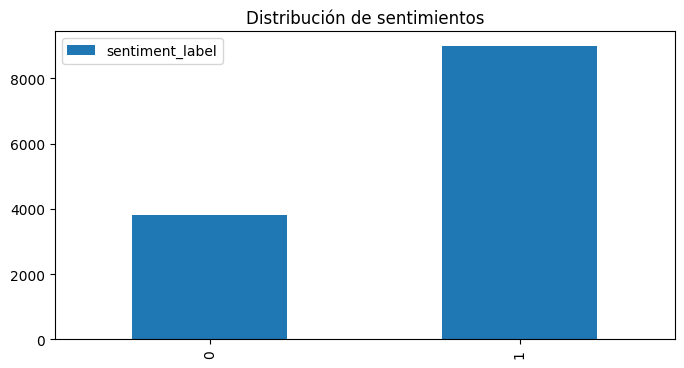

In [68]:
# mostramos un grafico de la distribucion de las reviews en funcion a su nueva etiqueta
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Distribución de sentimientos', figsize=(8, 4))

Tenemos un total de 1452815 palabras.


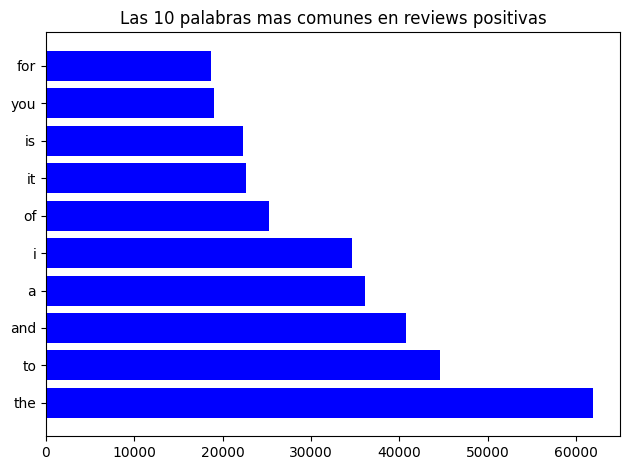

Tenemos un total de 792985 palabras.


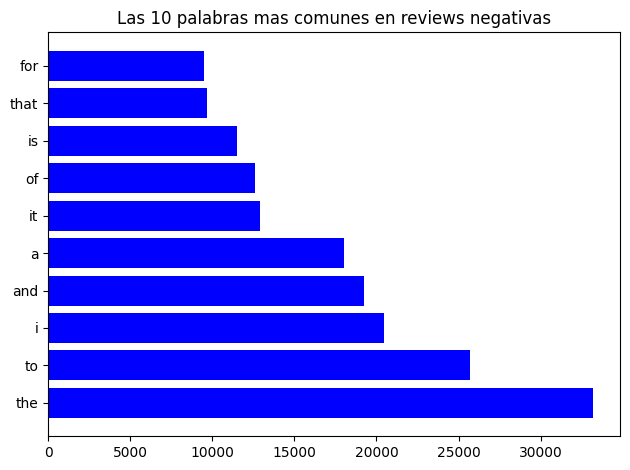

In [69]:
# visualizamos las palabras mas comunes por sentimiento
_ = counter_plot_most_common(reviews=df[df['sentiment_label'] == 1]['review'],num_palabras_mas_comunes=10, titulo='Las 10 palabras mas comunes en reviews positivas')
_ = counter_plot_most_common(reviews=df[df['sentiment_label'] == 0]['review'],num_palabras_mas_comunes=10, titulo='Las 10 palabras mas comunes en reviews negativas')

### Resumen de Visualización

Tras realizar una visualización inicial de los datos, se observaron las siguientes características:

1. **Stopwords presentes:**  
   Se identificó una gran cantidad de stopwords en los textos, las cuales serán eliminadas en el preprocesamiento posterior.

2. **Desbalanceo en los datos:**  
   Los datos presentan un desbalance significativo, siendo los sentimientos con puntuaciones de **4** y **5** los más comunes.

3. **Distribución binaria:**  
   Para facilitar el análisis, se realizó una transformación binaria de los resultados:  
   - **Reviews negativas:** Puntuaciones de **1**, **2**, y **3**.  
   - **Reviews positivas:** Puntuaciones de **4** y **5**.  

   Aunque esta transformación mejora la distribución de los datos, persiste el desbalance hacia las reviews positivas.

## PREPROCESADO DE LOS DATOS

### Limpiamos los corpus 

In [70]:
def limpieza_corpus(corpus):
    '''
        Lo primero que vamos a hacer al preprocesar es limipar los datos de caracteres especiales, urls,acentos, etc...  finalmente lo convertiremos los digitos en texto, pasamos todo en minusculas.
        Utilizaremos las expresiones regulares para ello y definiremos una funcion que realice toda la limpieza 
    '''
    # limpiamos con expresiones regulares
    corpus = re.sub(r'http\S+|www\S+', '', corpus)  # eliminamos url
    corpus = unicodedata.normalize('NFKD', corpus).encode('ascii', 'ignore').decode('utf-8', 'ignore') # eliminamos acentos
    corpus = re.sub(r'[^a-zA-Z0-9\s]', '', corpus)  # mantiene letras, números y espacios

    palabras_procesadas = list()
    
    # dividimos el corpus por espacio
    for palabra in corpus.split():

        # verificamos si la palabra es un digito, si es asi, lo pasamos a texto
        if palabra.isdigit():
            palabra = num2words(palabra, lang='en')
        
        # añadimos a la lista para luego reconstruir el corpus
        palabras_procesadas.append(palabra)
    
    corpus = ' '.join(palabras_procesadas) # reconstruimos el corpues
    corpus = corpus.lower()  # convertimos a minúsculas
    return corpus.strip() # eliminamos espacios

# los aplicamos a cada fila del dataframe
df['review_preprocessor'] = df['review'].apply(limpieza_corpus)

# comparamos algun corpus para verificar la limpieza
print('Corpus sin limpieza:', df['review'][14])
print('----------------')
print('Corpus limpiado:', df['review_preprocessor'][14])

Corpus sin limpieza: There are over 100 video lessons here. Most users have given this a high rating and I assume they are very comfortable with video learning. Personally I found it rather tedious.

I'd like to learn Lightroom because I've owned it for a while. I tried to use it but did not understand it so I went back to using Adobe Bridge, which is think is generally under-appreciated. I love Photoshop but tend to spend a lot of time with it, so the supposed time-saving features of Lightroom would be helpful.

I really hoped this product would make it easy for me to use Lightroom. Unfortunately I had trouble staying alert through more than 3 or 4 lessons at a time, and that much only covers a small portion of the material.  I don't think this is because of the presenters so much as it is the difficulty of covering this sort of material in a video format.

The Introduction alone consists of 26 videos. It seemed like a commercial for Lightroom rather than a tutorial. Seven of the less

### Eliminamos ruido de los corpus

In [71]:
# primero descargamos los stopwords en ingles
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def eliminar_stop_words(corpus):
    '''
    Quitamos los stopwords para eliminar ruido
    '''

    # tokenizamos las palabras para eliminar las stopwords 
    tokens = corpus.split()

    # recorremos cada lista de tokens y eliminamos las que esten dentro de la lista de stopwords
    filtro_stopwords = [palabra for palabra in tokens if palabra not in stop_words]

    # volvemos a unirlo todo en un corpus
    return ' '.join(filtro_stopwords)

# aplicamos la funcion sobre todas nuestros corpus preprocesado
df['review_preprocessor'] = df['review_preprocessor'].apply(eliminar_stop_words)

# mostramos el primer corpues preprocesado y con los stopwords eliminados
print('Corpus limpiado y eliminado los stopwords:', df['review_preprocessor'][14][:100])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Corpus limpiado y eliminado los stopwords: one hundred video lessons users given high rating assume comfortable video learning personally found


### Normalizamos los corpus con lematización

In [72]:
# instanciamos la clase de nlkt para lematizar
lemmatizer = WordNetLemmatizer()

def lematizar_corpus(corpus):
    '''
        Definimos una funcion para lematizar los corpus
    '''
    return " ".join(lemmatizer.lemmatize(palabra) for palabra in corpus.split())

# aplicamos la funcion sobre todas nuestros corpus preprocesado
df['review_preprocessor'] = df['review_preprocessor'].apply(lematizar_corpus)

# mostramos el primer corpues preprocesado y con los stopwords eliminados
print('Corpus limpiado,eliminado los stopwords y lematizando:', df['review_preprocessor'][14][:100])

Corpus limpiado,eliminado los stopwords y lematizando: one hundred video lesson user given high rating assume comfortable video learning personally found r


### Pipeline del preprocesado

In [73]:
# importamos los datos necesarios
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def pipeline_preprocessed(corpus):
    '''
        Definimos una pipeline de preprocesamiento de un corpus con todos los pasos anteriores.
    '''
    # declaramos una lista para ir almacenando el preprocesado
    procesado_corpus = list()

    # primero limpiamos cada corpus y passamos a minusculas
    corpus = re.sub(r'http\S+|www\S+', '', corpus)  # eliminamos url
    corpus = unicodedata.normalize('NFKD', corpus).encode('ascii', 'ignore').decode('utf-8', 'ignore') # eliminamos acentos
    corpus = re.sub(r'[^a-zA-Z0-9\s]', '', corpus)  # mantiene letras, números y espacios
    corpus = corpus.lower().strip()  # convertimos a minúsculas y quitamos espacios

    # segundo eliminamos stopwords y lematizamos y pasamos los digitos a numeros 
    # primero separamos las palabras por espacio y hacemos un bucle para recorrerlo
    for palabra in corpus.split():
        
        # verificamos si la palabra no se encuentra en la lista de stopwords y si es asi lo procesamos, si no, la desechamos
        if palabra not in stop_words:
            
            # verificamos si la palabra es un digito, si es asi, lo pasamos a texto
            if palabra.isdigit():
                palabra = num2words(palabra, lang='en')

            # lematizamos cada palabra 
            procesado_corpus.append(lemmatizer.lemmatize(palabra))


    # finalmente unimos el corpus para devolverlo 
    return " ".join(procesado_corpus)

df['review_preprocessor_pipeline'] = df['review'].apply(pipeline_preprocessed)


# verificamos que el preprocesado a traves del pipeline y las funciones es igual
assert df['review_preprocessor'][14][:100] == df['review_preprocessor_pipeline'][14][:100]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\manue\AppData\Local\Temp\ipykernel_20280\2673830224.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  palabras = split_review.apply(pd.Series).stack().reset_index(drop = True)


Tenemos un total de 1214228 palabras.


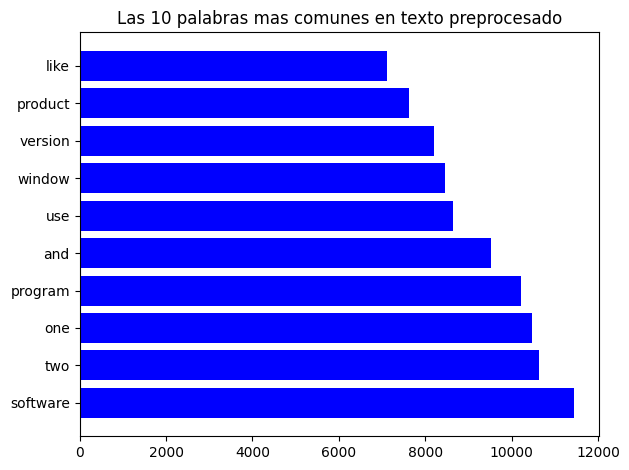

In [74]:
# una vez preprocesado el texto vamos a ver las palabras mas frecuentes
_ = counter_plot_most_common(reviews=df['review_preprocessor_pipeline'],num_palabras_mas_comunes=10, titulo='Las 10 palabras mas comunes en texto preprocesado')

Aun creo que podriamos seguir procesando datos y añadiendo stopwords por ejemplo para la palabra "and" pero aun asi lo eliminaremos con la TfidfVectorizer. Aun asi el preprocesado es correcto y hemos eliminado bastante ruido

## MODELADO DE DATOS Y ENTRENAMIENTO PARA MODELO DE MACHINE LEARNING
Para la representacion del texto voy a usar TfidfVectorizer porque ademas de ser una clase que realiza la tokenizacion y calcula la matriz de conteo me parece mas importante que se fija en palabras mas relevantes asignandoles mayor peso y eso en un analisis de sentimiento me parece importante


### Dividimos los datos

In [75]:
# dividimos los datos en un 75%/25%

X_train, X_test, y_train, y_test = train_test_split(
    df['review_preprocessor_pipeline'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [76]:
# observamos que los datos se ha dividido de manera proporcional
print(y_train.value_counts())
print(y_test.value_counts())

1    6732
0    2871
Name: sentiment_label, dtype: int64
1    2255
0     946
Name: sentiment_label, dtype: int64


In [77]:
# aplicamos la representacion de texto TfidfVectorizer, en los parametros añadidos hemos indicado:
# - excluya palabras que aparecen en mas del 95% del documento (asi eliminaremos la palabra "and")
# - que excluya palabras que aparecen en menos de 3 documentos
# - 4000 palabras de vocabulario
# - ngram de token por token 

td_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=4000,
    ngram_range=(1, 1)
)


### Entrenamiento del modelo
Para el entrenamiento, utilizaremos el modelo LogisticRegression con validacion cruzada para ver los mejores parametros

In [78]:
# primero vectorizamos los corpus

X_train_tfidf = td_vectorizer.fit_transform(X_train)
X_test_tfidf = td_vectorizer.transform(X_test)

# creamos una lista con los parametros que probara el gridSearch
param_grid = {
    'C': [0.1, 1.0, 10],              
    'solver': ['lbfgs'],              
    'max_iter': [500, 1000]          
}

# configuramos el gridsearch 
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,  
    scoring='f1',  # utilizamos f1-score porque al tener un dataframe desbalanceado, esta metrica nos asegura que el modelo no obtenga resultados aparentemente buenos solo porque favorece la clase mayoritaria.
)

# entrenamos el modelo 
grid.fit(X_train_tfidf, y_train)

# obtenemos los mejores parametros
print("Mejores parámetros:", grid.best_params_)
print("Mejor puntuación F1:", grid.best_score_)

Mejores parámetros: {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}
Mejor puntuación F1: 0.8839065221118154


In [79]:
# dados los mejores parametros, entrenamos el modelo con ellos 
lr = LogisticRegression(C=grid.best_params_['C'], solver=grid.best_params_['solver'], max_iter=grid.best_params_['max_iter'])
lr.fit(X_train_tfidf, y_train)

train_predict = lr.predict(X_train_tfidf)
test_predict = lr.predict(X_test_tfidf)

# calculamos el f1-score
train_f1 = f1_score(y_train, train_predict, average='binary')  
test_f1 = f1_score(y_test, test_predict, average='binary')


### Metricas

In [80]:
# mostramos los resultados del modelo para entramiento y test
print("F1-score (Train) para C={}: {:.4f}".format(grid.best_params_['C'], train_f1))
print("F1-score (Test) para C={}: {:.4f}".format(grid.best_params_['C'], test_f1))

F1-score (Train) para C=1.0: 0.9157
F1-score (Test) para C=1.0: 0.8831


In [81]:
print("Reporte de Clasificación (Train):")
print(classification_report(y_train, train_predict))

print("Reporte de Clasificación (Test):")
print(classification_report(y_test, test_predict))

Reporte de Clasificación (Train):
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      2871
           1       0.87      0.96      0.92      6732

    accuracy                           0.88      9603
   macro avg       0.88      0.82      0.84      9603
weighted avg       0.88      0.88      0.87      9603

Reporte de Clasificación (Test):
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       946
           1       0.84      0.93      0.88      2255

    accuracy                           0.83      3201
   macro avg       0.81      0.75      0.77      3201
weighted avg       0.82      0.83      0.82      3201



In [82]:
from sklearn.metrics import confusion_matrix

# calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, test_predict)

print(f' Los verdaderos negativos {conf_matrix[0][0]}')
print(f' Los falsos positivos {conf_matrix[0][1]}')
print(f' Los falsos negativos {conf_matrix[1][0]}')
print(f' Los verdaderos positivos {conf_matrix[1][1]}')

 Los verdaderos negativos 540
 Los falsos positivos 406
 Los falsos negativos 151
 Los verdaderos positivos 2104


### Conclusión

A partir de las métricas obtenidas, podemos destacar los siguientes puntos sobre el rendimiento del modelo de análisis de sentimiento:

- Recall (93%)
El modelo tiene un excelente desempeño al capturar la mayoría de los casos positivos, lo que indica que es eficaz para identificar reseñas clasificadas como positivas.

- Precisión (84%)
Aunque ligeramente más baja, la precisión sigue siendo sólida, lo que refleja que la mayoría de las predicciones positivas realizadas por el modelo son correctas. Sin embargo, todavía hay margen de mejora para reducir los falsos positivos.

- F1-score (88.2%)
Esta métrica muestra un buen equilibrio entre precisión y recall, lo que indica que el modelo gestiona de manera adecuada el compromiso entre evitar falsos positivos y capturar los verdaderos positivos.

- Falsos Positivos (409 casos)
La cantidad de falsos positivos es un punto de atención, ya que representa predicciones incorrectas donde el modelo clasificó como positivas reseñas que realmente eran negativas. Esto podría deberse al criterio utilizado durante la división de las etiquetas. En particular, las reviews con puntuación de **3** fueron etiquetadas como negativas. Dado que estas puntuaciones están en un rango ambiguo entre positivas y negativas, es probable que el modelo las haya considerado como positivas debido a la similitud con el contexto de reseñas favorables.


## CREACION DE WORD2VEC, MODELADO Y ENTRAMIENTO DE MODELO DE DEEP LEARNING

### Creación del word2vec

In [88]:
# tokenizamos los corpus para poder usarlo en la creacion del word2vec
corpus_tokenizado = [sentence.split() for sentence in df['review_preprocessor_pipeline']]

In [90]:
# declaramos el word2vec y sus hiperparametros
w2v_model = Word2Vec(min_count=15,
                     window=2,
                     vector_size=250,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,)

In [91]:
# contruimos el vocabulario y calculamos su tiempo
t = time()

w2v_model.build_vocab(corpus_tokenizado, progress_per=5000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para construir el vocabulario: 0.0 mins


In [95]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 5267 palabras


In [97]:
# entrenamos el modelo 
t = time()

w2v_model.train(corpus_tokenizado, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


print('Tiempo de entrenamiento del modelo : {} mins'.format(round((time() - t) / 60, 2)))

Tiempo de entrenamiento del modelo : 0.4 mins


In [98]:
# guardamos el modelo por si acaso tenemos que usarlo de nuevo, es una buena practica
w2v_model.save('./w2v_model_practicaNPL.pkl')

In [101]:
# realizamos una verificacion para comprobar si captura correctamente la semantica y contexto 
w2v_model.wv.most_similar(positive=["good"])

[('decent', 0.4853583872318268),
 ('great', 0.4464954733848572),
 ('better', 0.40558576583862305),
 ('excellent', 0.3673258423805237),
 ('best', 0.35929015278816223),
 ('bad', 0.3106391131877899),
 ('robust', 0.2992327809333801),
 ('reasonable', 0.29442742466926575),
 ('economical', 0.2937205731868744),
 ('comprehensive', 0.2898973524570465)]

In [112]:
similarity = w2v_model.wv.similarity("good", "great")
print(f"Similitud entre 'good' y 'great': {similarity}")


Similitud entre 'good' y 'great': 0.4464954733848572


Por lo que observamos captura correctamente las relaciones entre las palabras

### Creamos el corpus de palabras en un corpus de indices

In [118]:
# convierto palabras a índices basado en mi word2vec
corpus_indices = [
    [w2v_model.wv.key_to_index[word] for word in sentence if word in w2v_model.wv]
    for sentence in corpus_tokenizado
]


### Rellenamos o quitamos tokens
Aseguramos que todos los corpus tengan la misma longuitud

In [120]:
max = 0
mean = []
for example in corpus_indices:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

print(f'Media de los corpus {sum(mean) / len(mean)}')
print(f'Maximo de los corpus {max}')

Media de los corpus 89.41580756013745
Maximo de los corpus 2911


Dado este resultado, daremos una dimensión por corpus de 300

In [122]:
padded_sequences = pad_sequences(corpus_indices, maxlen=300)

In [124]:
print("Corpus rellenadas:", padded_sequences)

Corpus rellenadas: [[   0    0    0 ...  360   24   51]
 [   0    0    0 ...   39  193 2289]
 [ 803  976    5 ... 1559  291    3]
 ...
 [   0    0    0 ...  116  322  119]
 [   0    0    0 ...   22 1169  386]
 [   0    0    0 ...   22  193  871]]


### Generamos el embeddings

In [129]:

# creamos la matriz 
embedding_dim = w2v_model.vector_size  
vocab_size = len(w2v_model.wv)         

# inicializamos a zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# rellenamos la matriz 
for word, idx in w2v_model.wv.key_to_index.items():
    embedding_matrix[idx] = w2v_model.wv[word]

print("Matriz de embeddings:", embedding_matrix.shape)


Matriz de embeddings: (5267, 250)


### Dividimos los datos

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [133]:
# observamos que los datos se ha dividido de manera proporcional
print(y_train.value_counts())
print(y_test.value_counts())

1    6732
0    2871
Name: sentiment_label, dtype: int64
1    2255
0     946
Name: sentiment_label, dtype: int64


### Contruimos nuestra red neuronal LSTM

In [136]:
# creamos la red neuronal 

model_custom = Sequential()
model_custom.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=300, trainable=False),)
model_custom.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_custom.add(Dense(1, activation="sigmoid"))


# compilamos la red
model_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# entrenamos el modelo 
historico = model_custom.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

d:\Bootcamp IA\Practica NLP\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.7301 - loss: 0.5470 - val_accuracy: 0.7851 - val_loss: 0.4662
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step - accuracy: 0.7916 - loss: 0.4490 - val_accuracy: 0.7757 - val_loss: 0.4523
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.8074 - loss: 0.4166 - val_accuracy: 0.8066 - val_loss: 0.4191
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.8257 - loss: 0.3843 - val_accuracy: 0.8091 - val_loss: 0.4173
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.8331 - loss: 0.3694 - val_accuracy: 0.8160 - val_loss: 0.4064
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.8514 - loss: 0.3444 - val_accuracy: 0.8122 - val_loss: 0.4130
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8715 - loss: 0.3089 - val_accuracy: 0.8188 - val_loss: 0.4066
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.8703 - loss: 0

### Metricas

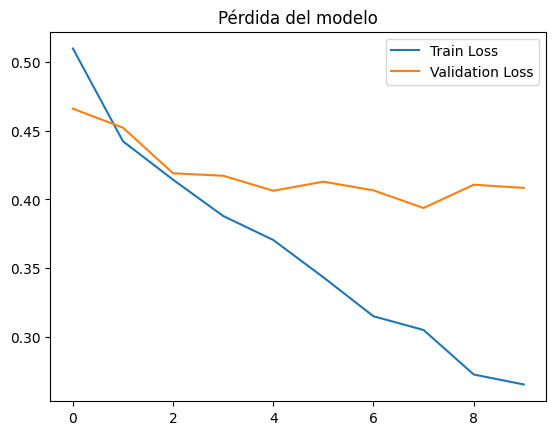

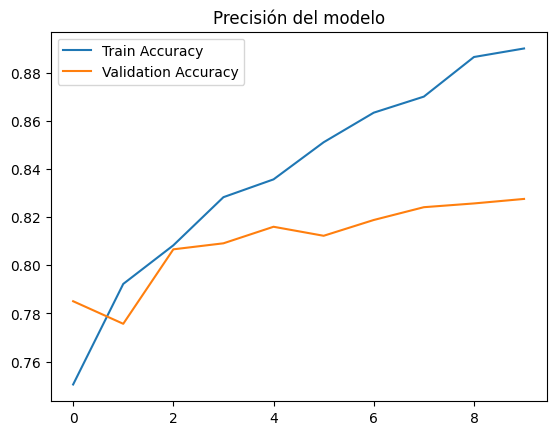

In [137]:
# primero al capturar el historico, mostramos una grafica de la perdida y precision 
plt.plot(historico.history['loss'], label='Train Loss')
plt.plot(historico.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Pérdida del modelo')
plt.show()

plt.plot(historico.history['accuracy'], label='Train Accuracy')
plt.plot(historico.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Precisión del modelo')
plt.show()

Observamos que en los datos de validación el crecimiento no ha sido tan grande como en los datos de train

In [138]:
# sacamos la metricas de f1 porque nuestros datos estan desvalanceados 

# predicciones en el conjunto de prueba
y_pred = model_custom.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Umbral de 0.5 para convertir probabilidades a clases

# calculo de métricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Precisión: 0.87
Recall: 0.89
F1-score: 0.88


In [139]:
# reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Mala', 'Buena']))

              precision    recall  f1-score   support

        Mala       0.72      0.68      0.70       946
       Buena       0.87      0.89      0.88      2255

    accuracy                           0.83      3201
   macro avg       0.80      0.78      0.79      3201
weighted avg       0.82      0.83      0.83      3201



### Conclusion

- La accuracy global del modelo es del 83%, lo que indica un desempeño sólido en términos de predicciones correctas para ambas clases.
- El F1-score ponderado también es de 0.83, lo que confirma un equilibrio adecuado entre precisión y recall en el conjunto de datos.
- Por lo general el modelo se comporta muy parecido al desarrollado con machine learning